In [16]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import matplotlib.pyplot as plt
import scipy.io
import multiprocessing
import scipy.stats as sts


%matplotlib notebook

Loading BokehJS ...

In [2]:
sm_beta = pystan.StanModel(file='rvk_model_beta.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b87582fea34dfc07e7370a7d307b89e NOW.


In [3]:
# Generate data using prior for prior-predictive check
sm_sim = pystan.StanModel(file='rvk_model_sim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_59edfca34e87c61ca152db0af32f199b NOW.


In [4]:
# Generate quantities from prior
R = 1000 # 100 trials
N = 100 # 100 time steps

sim_data = sm_sim.sampling(data={'N': N},
                     iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838284, algorithm="Fixed_param")

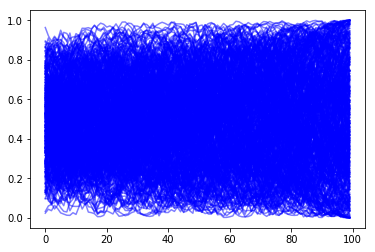

In [5]:
plt.figure()
plt.plot(sim_data['r'].T, 'b', alpha=0.5);

In [6]:
nantrials = np.isnan(sim_data['r'][:,0])

ysim = sim_data['y'][~nantrials,:]
rsim = sim_data['r'][~nantrials,:]
vsim = sim_data['v'][~nantrials]

In [10]:
# Find the posterior for each simulation
def analyze_simu(simu):
    simu_y = simu[0].astype('int')
    simu_v = simu[1]
    input_data=dict(N=N, y=simu_y)
    fit = sm_beta.sampling(data=input_data, seed=4938483, warmup=500, iter=1000, chains=4)
    warning_code = bebi103.stan.check_all_diagnostics(fit, quiet=True)
    print(warning_code)
    # Extract the v values
    vvals = fit['v']
    sbc_rank = np.sum(vvals > simu_v)
    
    # Compute posterior sensitivities
    summary = fit.summary(pars='v', probs=[0.5])
    post_mean_v = summary['summary'][0, 0]
    post_sd_v = summary['summary'][0, 2]
    
    prior_sd_v = 0.1
    
    z_score = (post_mean_v - simu_v) / post_sd_v
    shrinkage = 1 - (post_sd_v / prior_sd_v)**2
    
    return [warning_code, sbc_rank, z_score, shrinkage]

In [9]:
simu_y = ysim[0].astype('int')
simu_v = vsim[0]
input_data=dict(N=N, y=simu_y)
fit = sm_beta.sampling(data=input_data, seed=4938483, warmup=500, iter=1000, chains=4)

In [11]:
codes = []
ranks = []
zscores = []
shrinks = []
for i in range(100):
    print('Working on iteration', i)
    code, rank, zscore, shrink = analyze_simu([ysim[i], vsim[i]])
    codes.append(code)
    ranks.append(rank)
    zscores.append(zscores)
    shrinks.append(shrink)
    

Working on iteration 0
0
Working on iteration 1
0
Working on iteration 2
0
Working on iteration 3
0
Working on iteration 4
0
Working on iteration 5
0
Working on iteration 6
0
Working on iteration 7
0
Working on iteration 8
0
Working on iteration 9
0
Working on iteration 10
0
Working on iteration 11
0
Working on iteration 12
0
Working on iteration 13
0
Working on iteration 14
0
Working on iteration 15
0
Working on iteration 16
0
Working on iteration 17
0
Working on iteration 18
0
Working on iteration 19
0
Working on iteration 20
0
Working on iteration 21
0
Working on iteration 22
0
Working on iteration 23
0
Working on iteration 24
0
Working on iteration 25
0
Working on iteration 26
0
Working on iteration 27
0
Working on iteration 28
0
Working on iteration 29
0
Working on iteration 30
0
Working on iteration 31
0
Working on iteration 32
0
Working on iteration 33
0
Working on iteration 34
0
Working on iteration 35
0
Working on iteration 36
0
Working on iteration 37
0
Working on iteration 3

<IPython.core.display.Javascript object>


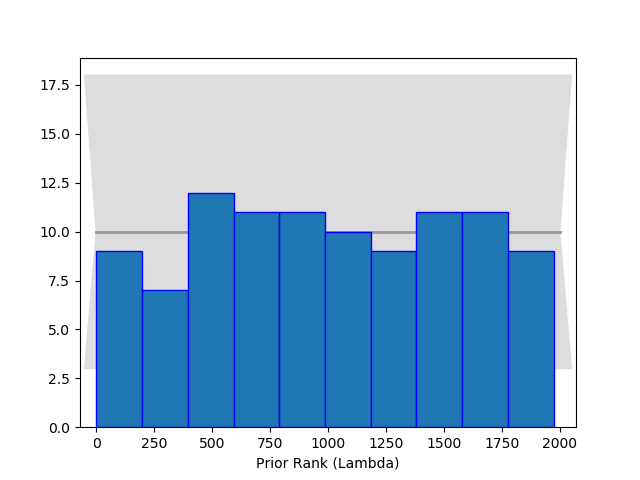

(-70, 2070)

In [33]:
plt.figure()

R = 100
protruding = 50

sbc_low = sts.binom.ppf(0.005, R, 10.0 / 100)
sbc_mid = sts.binom.ppf(0.5, R, 10.0 / 100)
sbc_high = sts.binom.ppf(0.995, R, 10.0 / 100)

bar_x = [-protruding, 2000 + protruding, 2000, 2000 + protruding, -protruding, 0, -protruding]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

plt.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plt.plot([0, 2000], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

plt.hist(ranks, ec='b', zorder=3)
plt.gca().set_xlabel("Prior Rank (Lambda)")
plt.gca().set_xlim(-protruding-20, 2000 + protruding+20)
